
# Part 4 — Sub-threshold Dynamics Before Spike Initiation

**Objective.** Quantify sub-threshold membrane potential dynamics within **10–20 ms** preceding threshold in the *quiet whisking* state and compare across **EXC, PV, SST, VIP**.  
Metrics per spike:
- Threshold voltage (mV) at dV/dt crossing  
- Pre-spike slope dV/dt (mV/ms) from linear fit over the last 10 or 20 ms
- Mean pre-spike Vm (mV)  
Also assess dependence on **ISI class** (short/medium/long) and **cortical depth**.

**Outputs.**
- Figures: threshold by class, slope vs ISI (10 ms), threshold vs depth, mean Vm by window & class
- Table: `p4_pre_spike_features.csv`


In [ ]:

# %% [config]
import os
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 150})


MAIN_DIR = r'/Users/angelinamatthey/Documents/BIO482_MiniProject_2025_Python'  # EDIT
DATA_DIR = os.path.join(MAIN_DIR, 'Data')
FIG_DIR  = os.path.join(MAIN_DIR, 'Figures'); os.makedirs(FIG_DIR, exist_ok=True)


CANDIDATE = ['Data_bio482.pkl']

# Analysis parameters
PRE_WINDOWS_MS = [10, 20]
REFRACTORY_MS  = 2.0
SHORT_ISI_MAX_MS = 20.0
LONG_ISI_MIN_MS  = 100.0
MIN_SAMPLES_PER_SPIKE = 10
DEFAULT_FS_HZ = 20_000.0

# Canonical column names (resolved robustly later)
COL_CELL_ID   = 'Cell_ID'
COL_CELL_TYPE = 'Cell_Type'
COL_STATE     = 'Sweep_Type'
COL_DEPTH     = 'Cortical_Depth_um'
COL_VM        = 'Vm'
COL_FS        = 'Fs_Hz'

# State label helpers
QUIET_WHISKING_LABELS = ['quiet whisking','quiet_whisking','quietwhisking','quiet']


In [2]:

# %% [utilities]
def find_first_existing(names: List[str], base: str) -> Optional[str]:
    for n in names:
        p = os.path.join(base, n)
        if os.path.exists(p): return p
    return None

def robust_get_col(df: pd.DataFrame, names: List[str]) -> Optional[str]:
    # Case-insensitive exact matching
    lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return n
        if n.lower() in lower: return lower[n.lower()]
    return None

def find_col_by_substring(df: pd.DataFrame, needles: List[str]) -> Optional[str]:
    # First column containing any of the substrings
    for c in df.columns:
        cl = c.lower()
        if any(nd in cl for nd in needles): return c
    return None

def looks_like_trace(x) -> bool:
    # Accept 1D numeric-like sequence with sufficient length
    try:
        arr = np.asarray(x, dtype=float)
        return arr.ndim == 1 and arr.size >= MIN_SAMPLES_PER_SPIKE
    except Exception:
        return False

def maybe_convert_units_to_mV(v: np.ndarray) -> Tuple[np.ndarray, bool]:
    # Heuristic: intracellular mV swings ~ tens of mV; Volts swings << 1
    amp = np.nanpercentile(v, 99) - np.nanpercentile(v, 1)
    if amp < 0.5:  # likely Volts
        return v * 1000.0, True
    return v, False

def linear_slope(x_ms: np.ndarray, y_mV: np.ndarray) -> float:
    x = x_ms - x_ms.mean()
    denom = float(np.dot(x, x))
    if denom == 0.0: return np.nan
    return float(np.dot(x, (y_mV - y_mV.mean())) / denom)

def extract_from_segment(seg_mV: np.ndarray, fs_hz: float) -> Tuple[float, float]:
    if seg_mV is None or len(seg_mV) < MIN_SAMPLES_PER_SPIKE: return (np.nan, np.nan)
    t_ms = np.arange(seg_mV.size) * (1000.0 / fs_hz)
    return linear_slope(t_ms, seg_mV), float(np.mean(seg_mV))

def robust_mad(x: np.ndarray) -> float:
    med = float(np.nanmedian(x))
    return float(np.nanmedian(np.abs(x - med)) * 1.4826)

def savefig(name: str):
    fp = os.path.join(FIG_DIR, name)
    plt.savefig(fp, bbox_inches="tight")
    print("Saved:", fp)


In [ ]:

# %% [load data]
pkl = find_first_existing(CANDIDATE, DATA_DIR)
if pkl:
    data_df = pd.read_pickle(pkl)
else:
    # Synthetic fallback keeps the notebook runnable end-to-end
    rng = np.random.default_rng(0)
    fs = DEFAULT_FS_HZ
    T = 1.0; N = int(fs*T)
    def synth_trace(fr=5.0, noise=0.25, baseline=-65.0):
        v = baseline + noise * rng.standard_normal(N)
        isi = int(fs/max(fr,0.1))
        for t in range(2000, N, isi):
            if t+6 < N:
                v[t:t+3]   += np.array([2, 8, 20])
                v[t+3:t+6] += np.array([10, 5, 0])
        return v
    rows = []
    for ctype in ['EXC','PV','SST','VIP']:
        for c in range(3):
            cid = f"mouseX_{ctype}_{c}"
            depth = float({'EXC':400,'PV':300,'SST':600,'VIP':220}[ctype] + rng.normal(0,30))
            for sweep in range(3):
                rows.append({
                    COL_CELL_ID: cid, COL_CELL_TYPE: ctype, COL_STATE: 'quiet whisking',
                    COL_DEPTH: depth, COL_VM: synth_trace(fr=5+rng.normal(0,1.5)).astype(float), COL_FS: fs
                })
    data_df = pd.DataFrame(rows)

print("Data shape:", data_df.shape)
print("Columns:", list(data_df.columns))
display(data_df.head(3))


Data shape: (831, 24)
Columns: ['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth', 'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type', 'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype', 'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter', 'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate', 'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime', 'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate', 'Sweep_WhiskingTimes']


,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]"
1,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006..."
2,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]"


In [4]:

# %% [harmonize schema]
# Resolve column names
cell_id_col   = robust_get_col(data_df, [COL_CELL_ID, 'cell_id','CellId','cellID'])
cell_type_col = robust_get_col(data_df, [COL_CELL_TYPE,'cell_class','Type','type'])
state_col     = robust_get_col(data_df, [COL_STATE,'State','state','Behavior_State','Whisk_State'])
depth_col     = robust_get_col(data_df, [COL_DEPTH,'Depth_um','depth_um','Depth','CorticalDepth_um'])
vm_col        = robust_get_col(data_df, [COL_VM,'vm','Vm_mV','vm_mV','Voltage','Voltage_mV','Vm_trace','VoltageTrace'])
if vm_col is None:
    vm_col = find_col_by_substring(data_df, ['vm','volt','membrane','trace'])
fs_col        = robust_get_col(data_df, [COL_FS,'fs','Fs','FS','sampling_rate','SampleRate_Hz'])

# Fill defaults when absent
if fs_col is None:
    fs_col = COL_FS
    if fs_col not in data_df.columns: data_df[fs_col] = DEFAULT_FS_HZ
if depth_col is None:
    depth_col = 'Depth_um'
    if depth_col not in data_df.columns: data_df[depth_col] = np.nan

# Validate required
missing = []
if not cell_id_col:   missing.append(COL_CELL_ID)
if not cell_type_col: missing.append(COL_CELL_TYPE)
if not state_col:     missing.append(COL_STATE)
if not vm_col:        missing.append(COL_VM)
if missing:
    # Suggest vm-like candidates if Vm missing
    vm_candidates = []
    for c in data_df.columns:
        s = data_df[c].dropna()
        if not s.empty and looks_like_trace(s.iloc[0]): vm_candidates.append(c)
    raise AssertionError(f"Missing required columns: {missing}. Vm-like candidates: {vm_candidates}")

# Validate Vm content
samp = data_df[vm_col].dropna()
if samp.empty or not looks_like_trace(samp.iloc[0]):
    raise AssertionError(f"Column '{vm_col}' does not contain per-sweep 1D traces.")

print("Resolved columns →",
      dict(cell_id=cell_id_col, cell_type=cell_type_col, state=state_col, depth=depth_col, vm=vm_col, fs=fs_col))


Resolved columns → {'cell_id': 'Cell_ID', 'cell_type': 'Cell_Type', 'state': 'Sweep_Type', 'depth': 'Depth_um', 'vm': 'Sweep_MembranePotential', 'fs': 'Fs_Hz'}


In [5]:

# %% [state filter: quiet whisking]
norm = data_df[state_col].astype(str).str.strip().str.lower()
print("State labels (top 20):")
display(norm.value_counts().head(20))

# Build mask using explicit synonyms + ('quiet' AND 'whisk') fallback
explicit_qw = [
    r'^quiet\s*whisk(ing)?$', r'quiet[_\-\s]*whisk(ing)?', r'\bqw\b',
    r'whisk(ing)?\s*\(quiet\)', r'whisk(ing)?[_\-\s]*quiet', r'low[_\-\s]*whisk(ing)?'
]
mask_qw = norm.str.contains('quiet') & norm.str.contains('whisk')
for pat in explicit_qw:
    mask_qw = mask_qw | norm.str.contains(pat, regex=True)

fallback_used = False
if int(mask_qw.sum()) == 0:
    any_whisk = norm.str.contains(r'\bwhisk', regex=True)
    if int(any_whisk.sum()) > 0:
        print("[WARN] No explicit 'quiet whisking' sweeps found. Using ANY 'whisk' state.")
        mask_qw = any_whisk
        fallback_used = True
    else:
        raise AssertionError("No sweeps after quiet-whisking/whisking filter. Adjust patterns above.")

df_qw = data_df.loc[mask_qw].copy()
print(f"Selected sweeps: {df_qw.shape[0]} (fallback={'YES' if fallback_used else 'NO'})")
display(df_qw[state_col].value_counts())


State labels (top 20):


Sweep_Type
free whisking      497
active touch       331
passive contact      3
Name: count, dtype: int64

[WARN] No explicit 'quiet whisking' sweeps found. Using ANY 'whisk' state.
Selected sweeps: 497 (fallback=YES)


/var/folders/q5/jhvt8jbs4zs9gvx_44j58pg00000gn/T/ipykernel_10034/3647695642.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_qw = mask_qw | norm.str.contains(pat, regex=True)


Sweep_Type
free whisking    497
Name: count, dtype: int64

In [6]:

# %% [detect spikes & compute features]
@dataclass
class SpikeFeature:
    cell_id: str
    cell_type: str
    depth_um: float
    isi_ms: float
    isi_class: str
    window_ms: int
    threshold_mV: float
    slope_mV_per_ms: float
    mean_vm_mV: float

def isi_classify(isi_ms: float) -> str:
    if np.isnan(isi_ms): return 'NaN'
    if isi_ms <= SHORT_ISI_MAX_MS: return 'short'
    if isi_ms >= LONG_ISI_MIN_MS:  return 'long'
    return 'medium'

features: List[SpikeFeature] = []
total_spikes = 0
print("=== Spike detection diagnostics per cell ===")
for cid, g in df_qw.groupby(df_qw[cell_id_col]):
    ctype = str(g[cell_type_col].iloc[0])
    depth = float(g[depth_col].iloc[0]) if depth_col in g else np.nan
    fs    = float(g[fs_col].iloc[0]) if fs_col in g else DEFAULT_FS_HZ
    dt_ms = 1000.0 / fs

    v_all = np.concatenate([np.asarray(x, dtype=float).ravel() for x in g[vm_col].tolist()])
    v_all, converted = maybe_convert_units_to_mV(v_all)

    dvdt = np.diff(v_all) / dt_ms
    med = float(np.nanmedian(dvdt)); mad = robust_mad(dvdt)
    k = 10.0  # sensitivity
    thr = max(med + k*max(mad, 1e-6), 2.0)

    cand = np.where(dvdt >= thr)[0] + 1
    min_sep = int(round(REFRACTORY_MS / dt_ms))
    spikes = []
    last = -10**9
    for idx in cand:
        if idx - last >= min_sep:
            spikes.append(idx); last = idx
    spikes = np.asarray(spikes, dtype=int)

    print(f"[{cid}] sweeps={g.shape[0]} fs={fs:.0f}Hz units={'mV' if not converted else 'V→mV'} "
          f"cand={len(cand)} spikes={len(spikes)} thr={thr:.2f} mV/ms (med/MAD={med:.2f}/{mad:.2f})")

    if spikes.size == 0: continue

    isi_ms = np.diff(spikes) * dt_ms
    isi_ms = np.concatenate([[np.nan], isi_ms])

    for i, thr_idx in enumerate(spikes):
        if thr_idx <= 0 or thr_idx >= len(v_all): continue
        thr_v = float(v_all[thr_idx])
        for win in PRE_WINDOWS_MS:
            n_pre = int(round(win * fs / 1000.0))
            if thr_idx - n_pre < 1: continue
            seg = v_all[thr_idx - n_pre:thr_idx]
            slope, mean_vm = extract_from_segment(seg, fs)
            features.append(SpikeFeature(
                cell_id=str(cid), cell_type=str(ctype), depth_um=float(depth) if not np.isnan(depth) else np.nan,
                isi_ms=float(isi_ms[i]) if i < len(isi_ms) else np.nan, isi_class=isi_classify(float(isi_ms[i])) if i < len(isi_ms) else 'NaN',
                window_ms=int(win), threshold_mV=thr_v, slope_mV_per_ms=float(slope), mean_vm_mV=float(mean_vm)
            ))
    total_spikes += spikes.size

features_df = pd.DataFrame([f.__dict__ for f in features])
print("Extracted spikes (total):", total_spikes)
print("Feature rows:", features_df.shape[0])
display(features_df.head(5))


=== Spike detection diagnostics per cell ===
[AP032_1] sweeps=6 fs=20000Hz units=V→mV cand=27659 spikes=3531 thr=14.70 mV/ms (med/MAD=-0.13/1.48)
[AP032_2] sweeps=1 fs=20000Hz units=V→mV cand=3025 spikes=375 thr=11.92 mV/ms (med/MAD=-0.12/1.20)
[AP035_1] sweeps=3 fs=20000Hz units=V→mV cand=10056 spikes=1232 thr=12.85 mV/ms (med/MAD=-0.13/1.30)
[AP035_2] sweeps=5 fs=20000Hz units=V→mV cand=22428 spikes=3348 thr=15.63 mV/ms (med/MAD=-0.13/1.58)
[AP039_1] sweeps=3 fs=20000Hz units=V→mV cand=243 spikes=28 thr=5.56 mV/ms (med/MAD=0.00/0.56)
[AP039_2] sweeps=4 fs=20000Hz units=V→mV cand=6029 spikes=447 thr=5.56 mV/ms (med/MAD=0.00/0.56)
[AP040_1] sweeps=2 fs=20000Hz units=V→mV cand=2842 spikes=262 thr=5.56 mV/ms (med/MAD=0.00/0.56)
[AP040_2] sweeps=5 fs=20000Hz units=V→mV cand=3422 spikes=490 thr=6.43 mV/ms (med/MAD=-0.06/0.65)
[AP040_3] sweeps=3 fs=20000Hz units=V→mV cand=462 spikes=61 thr=5.56 mV/ms (med/MAD=0.00/0.56)
[AP056_1] sweeps=8 fs=20000Hz units=V→mV cand=7957 spikes=704 thr=7.35 

,cell_id,cell_type,depth_um,isi_ms,isi_class,window_ms,threshold_mV,slope_mV_per_ms,mean_vm_mV
0,AP032_1,PV,NaN,NaN,NaN,10,-49.212500,-0.344333,-59.898328
1,AP032_1,PV,NaN,NaN,NaN,20,-49.212500,-0.025124,-60.075703
2,AP032_1,PV,NaN,130.50,long,10,-53.171877,0.343800,-56.570047
3,AP032_1,PV,NaN,130.50,long,20,-53.171877,0.002245,-56.338281
4,AP032_1,PV,NaN,240.45,long,10,-40.312499,-0.224110,-47.470844


Saved: /Users/angelinamatthey/Documents/BIO482_MiniProject_2025_Python/Figures/p4_threshold_by_cellclass.png


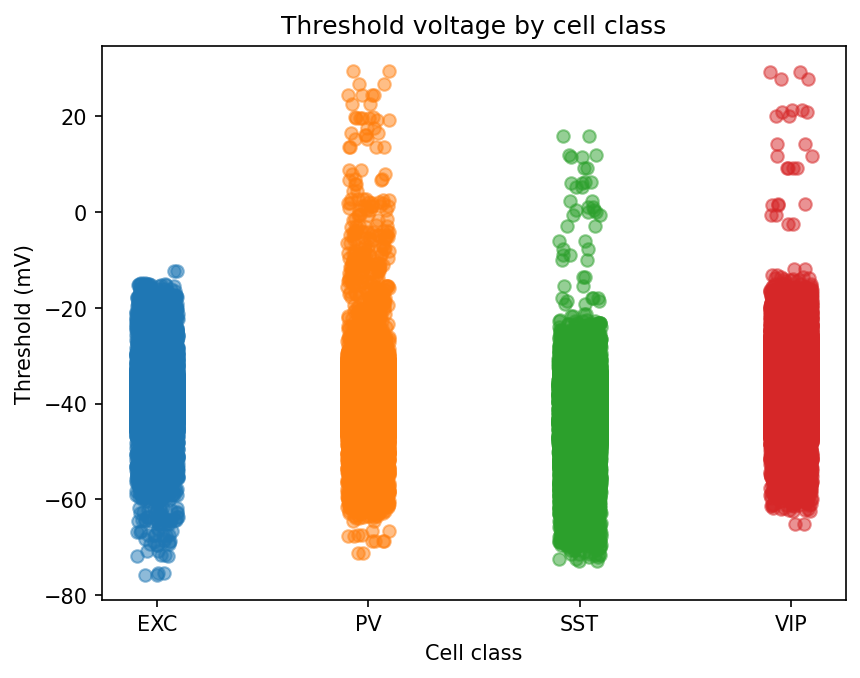

Saved: /Users/angelinamatthey/Documents/BIO482_MiniProject_2025_Python/Figures/p4_slope_vs_isi_10ms.png


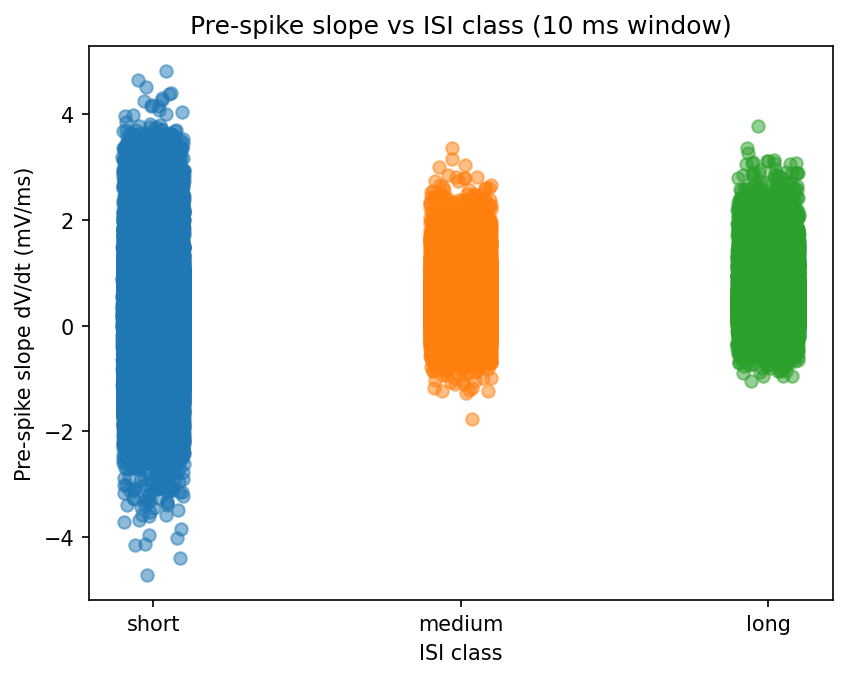

[INFO] No depth+threshold pairs to plot.


<Figure size 960x720 with 0 Axes>

Saved: /Users/angelinamatthey/Documents/BIO482_MiniProject_2025_Python/Figures/p4_mean_vm_by_window_cellclass.png


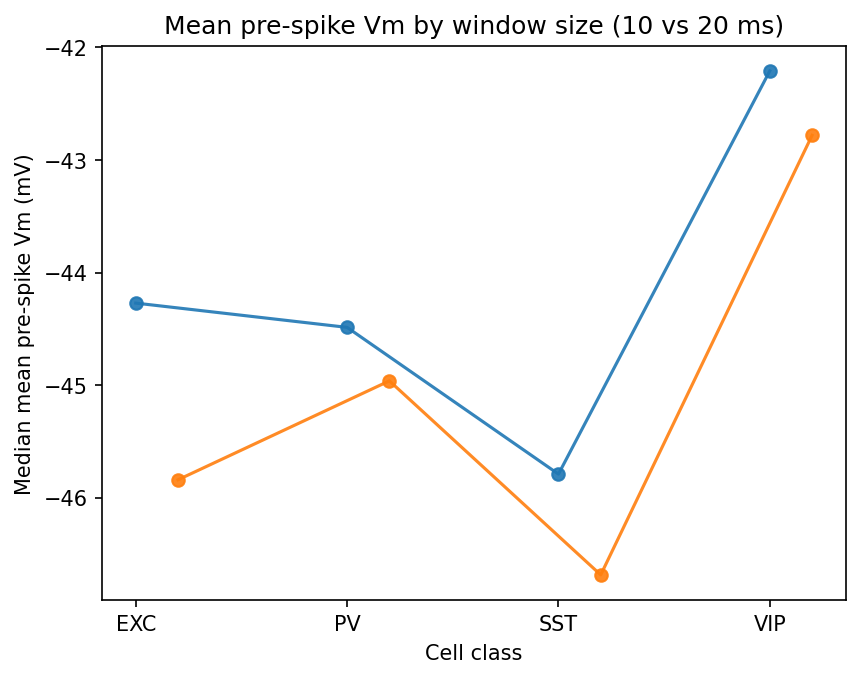

In [7]:

# %% [figures]
# 1) Threshold by cell class
plt.figure()
if not features_df.empty:
    classes = sorted(features_df['cell_type'].dropna().unique().tolist())
    for j, ct in enumerate(classes):
        vals = features_df.loc[features_df['cell_type']==ct, 'threshold_mV'].astype(float).dropna().values
        if vals.size == 0: continue
        x = np.full_like(vals, j, dtype=float) + (np.random.rand(vals.size)-0.5)*0.2
        plt.plot(x, vals, 'o', alpha=0.5)
    plt.xticks(range(len(classes)), classes)
plt.xlabel("Cell class"); plt.ylabel("Threshold (mV)"); plt.title("Threshold voltage by cell class")
savefig("p4_threshold_by_cellclass.png"); plt.show()

# 2) Pre-spike slope vs ISI class (10 ms window)
plt.figure()
sub10 = features_df[(features_df.get('window_ms', pd.Series(dtype=float))==10) & features_df['slope_mV_per_ms'].notna()] if not features_df.empty else pd.DataFrame()
isi_bins = ['short','medium','long']; plotted=False
for j, lab in enumerate(isi_bins):
    if sub10.empty: continue
    vals = sub10.loc[sub10['isi_class']==lab, 'slope_mV_per_ms'].astype(float).dropna().values
    if vals.size == 0: continue
    x = np.full_like(vals, j, dtype=float) + (np.random.rand(vals.size)-0.5)*0.2
    plt.plot(x, vals, 'o', alpha=0.5); plotted=True
plt.xticks(range(len(isi_bins)), isi_bins)
plt.xlabel("ISI class"); plt.ylabel("Pre-spike slope dV/dt (mV/ms)"); plt.title("Pre-spike slope vs ISI class (10 ms window)")
if not plotted: print("[INFO] No slope points for 10 ms window.")
savefig("p4_slope_vs_isi_10ms.png"); plt.show()

# 3) Threshold vs cortical depth
plt.figure()
valid = features_df.dropna(subset=['threshold_mV']) if not features_df.empty else pd.DataFrame()
valid = valid[valid.get('depth_um', pd.Series(dtype=float)).notna()] if not valid.empty else valid
if valid is not None and not valid.empty:
    plt.plot(valid['depth_um'].values, valid['threshold_mV'].values, 'o', alpha=0.4)
    plt.xlabel("Cortical depth (µm)"); plt.ylabel("Threshold (mV)"); plt.title("Threshold vs. cortical depth")
    savefig("p4_threshold_vs_depth.png")
else:
    print("[INFO] No depth+threshold pairs to plot.")
plt.show()

# 4) Mean pre-spike Vm by window size and cell class
plt.figure()
plotted=False
if not features_df.empty:
    for win in sorted(pd.unique(features_df['window_ms'].dropna())):
        sub = features_df[(features_df['window_ms']==win) & features_df['mean_vm_mV'].notna()]
        if sub.empty: continue
        m = sub.groupby('cell_type', dropna=False)['mean_vm_mV'].median().dropna()
        if m.empty: continue
        xs = np.arange(m.shape[0]) + (0.2 if win==20 else 0.0)
        plt.plot(xs, m.values, 'o-', alpha=0.9); plotted=True
labels = sorted(features_df['cell_type'].dropna().unique()) if not features_df.empty else []
plt.xticks(range(len(labels)), labels)
plt.xlabel("Cell class"); plt.ylabel("Median mean pre-spike Vm (mV)"); plt.title("Mean pre-spike Vm by window size (10 vs 20 ms)")
if plotted: savefig("p4_mean_vm_by_window_cellclass.png")
else: print("[INFO] No mean Vm data to plot.")
plt.show()


In [8]:

# %% [export]
out_csv = os.path.join(FIG_DIR, "p4_pre_spike_features.csv")
features_df.to_csv(out_csv, index=False)
print("Exported features to:", out_csv)


Exported features to: /Users/angelinamatthey/Documents/BIO482_MiniProject_2025_Python/Figures/p4_pre_spike_features.csv


In [9]:

# %% [qc peek]
if not features_df.empty:
    display(features_df.groupby(['cell_type','window_ms'])[['threshold_mV','slope_mV_per_ms','mean_vm_mV']].median())
else:
    print("[INFO] features_df is empty — check spike detection diagnostics above (threshold, MAD, state labels).")


threshold_mV  slope_mV_per_ms  mean_vm_mV
cell_type window_ms                                           
EXC       10           -39.066833         0.470559  -44.271563
          20           -39.066833         0.330273  -45.841244
PV        10           -39.278124         0.147464  -44.487269
          20           -39.278124         0.071630  -44.962487
SST       10           -40.799919         0.310650  -45.790881
          20           -40.799919         0.181799  -46.686159
VIP       10           -38.387500         0.301034  -42.208594
          20           -38.387500         0.146677  -42.781195